# C-VAE on minst dataset

Source: https://arxiv.org/pdf/1312.6114.pdf <br>

 ## Data Loading

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(xtr,ytr),(xtest,ytest) = mnist.load_data()

num_labels = len(np.unique(ytr))
input_shape = (28,28,1)
label_shape = (num_labels,)


xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255
xtest = xtest.reshape((-1,28,28,1)).astype('float32')/255

lengthMinstData = 28*28

## Model Creation

In [2]:
import os
from tensorflow.keras.layers import Dense,Reshape ,Lambda, Input, Flatten, Conv2D, Conv2DTranspose,concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy
import numpy as np

In [3]:
# Model parametres
latentSize = 2
denseSize = 512
epoch = 30
beta = 1.5

### Encoder

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]# number of records
    dim = K.int_shape(z_mean)[1] # shape of the matrix
    epsilon = K.random_normal( shape=(batch,dim) )
    
    return z_mean + K.exp( 0.5 * z_log_var ) * epsilon

In [6]:
inputs = Input(shape=input_shape ,name='encoder_input')
y_labels = Input(shape=label_shape,name='class_label')

x = Dense(lengthMinstData)(y_labels)

x = Reshape(input_shape)(x)


x = concatenate([inputs, x])

x =Conv2D(activation='relu',filters=32, kernel_size=3,strides=2,padding='same')(x)
x =Conv2D(activation='relu',filters=64, kernel_size=3,strides=2,padding='same')(x)

shp = K.int_shape(x)
x = Flatten()(x)


x = Dense(denseSize,activation='relu')(x)

z_mean =  Dense(latentSize ,name='z_mean')(x)
z_log_var =  Dense(latentSize,name='z_log_var')(x)
z = Lambda(function=sampling,output_shape=(latentSize,),name='z')([z_mean,z_log_var])


encoder = Model([inputs,y_labels],[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_label (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          8624        class_label[0][0]                
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_2[0][0]                    
____________________________________________________________________________________________

### Decoder

In [7]:
latent_inputs = Input(shape=(latentSize,), name="z_sampling")
x = concatenate([latent_inputs,y_labels])

x = Dense( shp[1]*shp[2]*shp[3] ,activation='relu')(x)
x = Reshape( (shp[1],shp[2],shp[3]) )(x)

x =Conv2DTranspose(activation='relu',filters=64, kernel_size=3,strides=2,padding='same')(x)
x =Conv2DTranspose(activation='relu',filters=32, kernel_size=3,strides=2,padding='same')(x)

outputs = Conv2DTranspose(filters=1,kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = Model([latent_inputs,y_labels],outputs,name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
class_label (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12)           0           z_sampling[0][0]                 
                                                                 class_label[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 3136)         40768       concatenate_2[0][0]        

### VAE

In [8]:
outputs = decoder( [encoder([inputs,y_labels])[2],y_labels] )
vae = Model([inputs,y_labels],outputs,name='VAE_Cond')
vae.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_1:0
Model: "VAE_Cond"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
class_label (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 1635924     encoder_input[0][0]              
                                                                 class_label[0][0]                
_______________________________________________________

## Loss


### Reconstruction Loss


In [9]:
reconstruction_mse = mse( K.flatten(inputs),K.flatten(outputs))

In [10]:
reconstruction_crossEntropy = binary_crossentropy( K.flatten(inputs),K.flatten(outputs))

### Kl loss

In [11]:
kl_loss = -beta * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)/2

### Global loss

In [12]:
vae_loss = K.mean( kl_loss + reconstruction_crossEntropy*lengthMinstData)

## Training

In [13]:
#Compile vae model
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [14]:
vae.fit(x=[xtr,to_categorical(ytr)],epochs=epoch,batch_size=1024,validation_data=[[xtest,to_categorical(ytest)],None])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 14s 227us/sample - loss: 243.8974 - val_loss: 179.4825
Epoch 2/30
60000/60000 [==============================] - 10s 159us/sample - loss: 162.3835 - val_loss: 151.3407
Epoch 3/30
60000/60000 [==============================] - 10s 159us/sample - loss: 149.9278 - val_loss: 146.4864
Epoch 4/30
60000/60000 [==============================] - 10s 165us/sample - loss: 146.1295 - val_loss: 144.2076
Epoch 5/30
60000/60000 [==============================] - 10s 170us/sample - loss: 143.8305 - val_loss: 142.1320
Epoch 6/30
60000/60000 [==============================] - 10s 173us/sample - loss: 142.3250 - val_loss: 141.1658
Epoch 7/30
60000/60000 [==============================] - 11s 175us/sample - loss: 140.9282 - val_loss: 142.0836
Epoch 8/30
60000/60000 [==============================] - 10s 175us/sample - loss: 140.1501 - val_loss: 138.8330
Epoch 9/30
60000/60000 [======================

### Vizualisation

In [20]:
from matplotlib import pyplot as plt
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    # display a 2D plot of the digit classes in the latent space
    z_mean,_,_ = encoder.predict([x_test,to_categorical(y_test)],
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    # display a 30x30 2D manifold of digits
    
    for yval in range(10):    
        n = 10
        digit_size = 28
        figure = np.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)[::-1]
        
        y = np.eye(10)[yval].reshape(1,10,)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict([z_sample,y])
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(10, 10))
        start_range = digit_size // 2
        end_range = (n - 1) * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.title('CVAE digit: {}'.format(yval))
        plt.show()

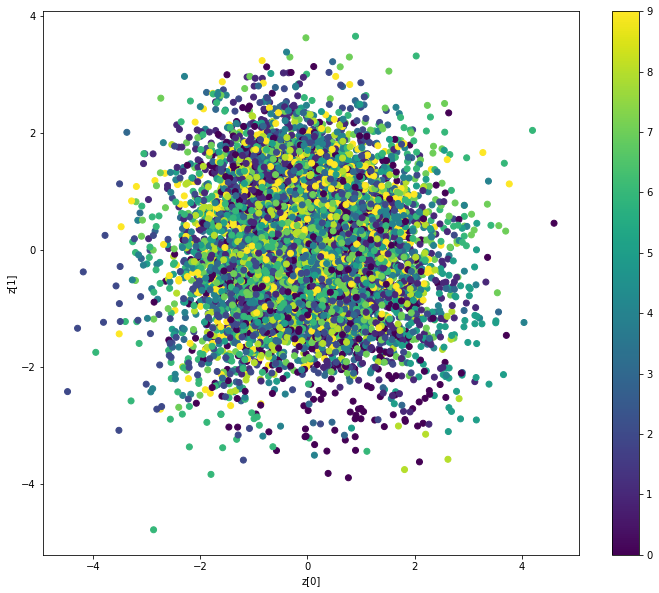

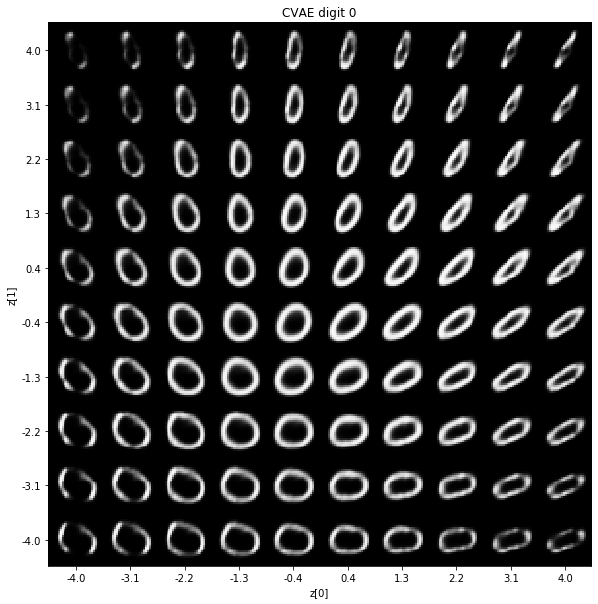

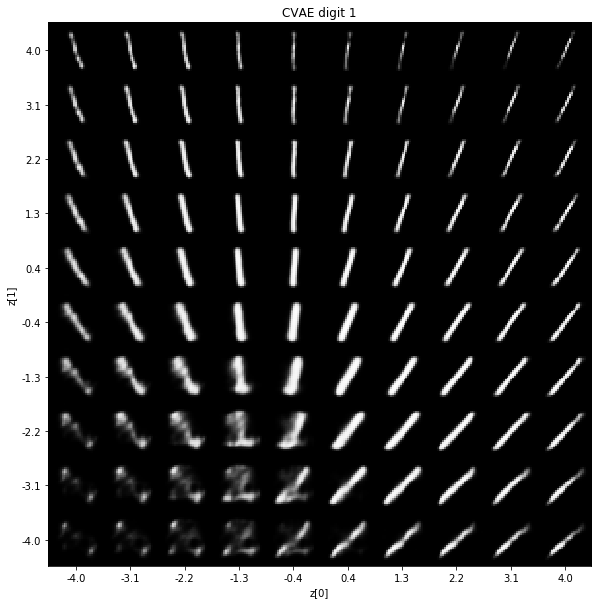

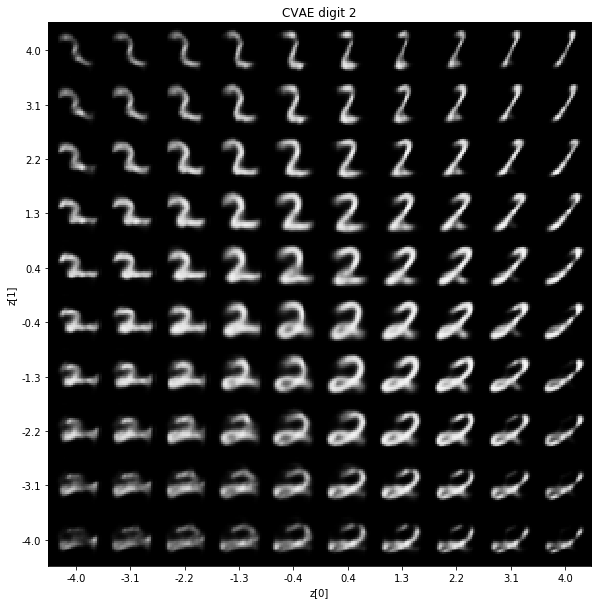

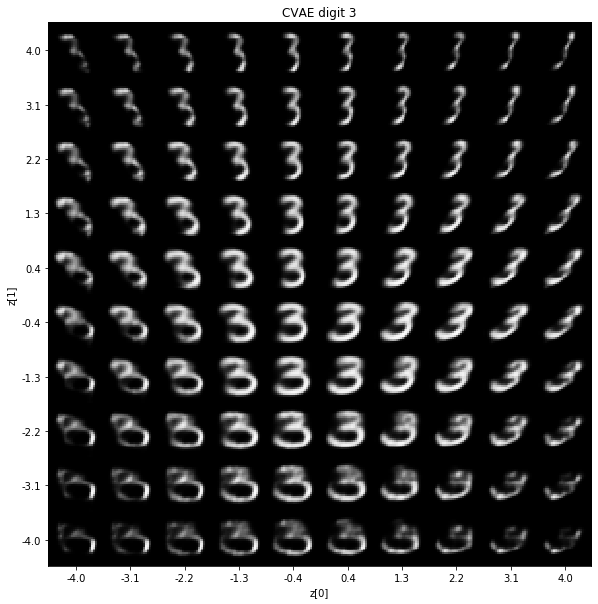

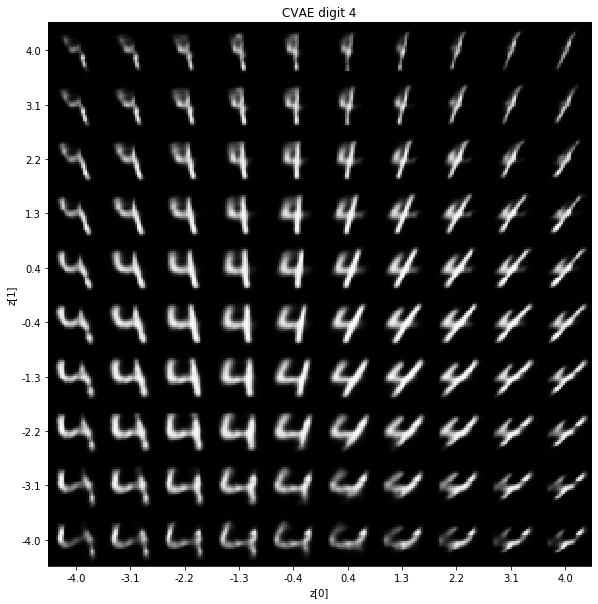

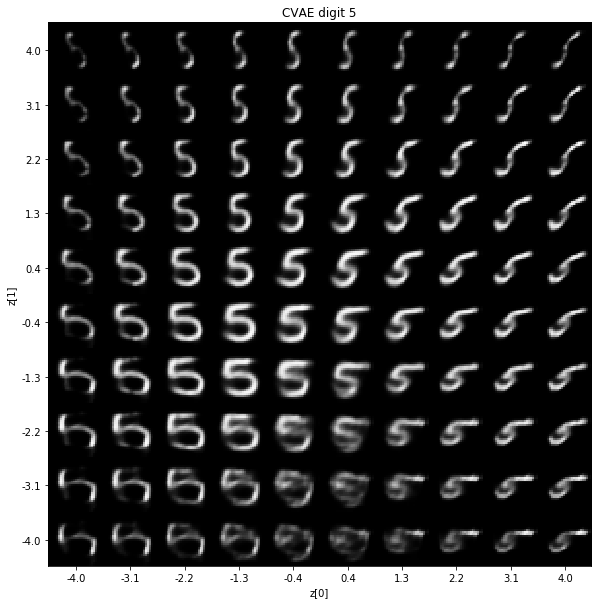

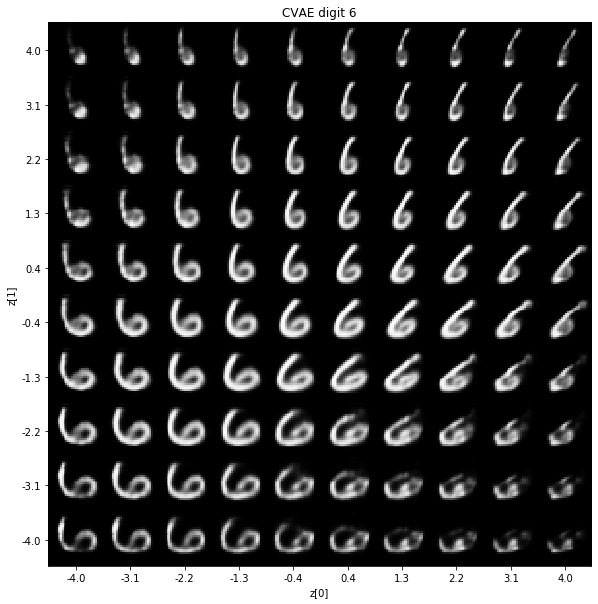

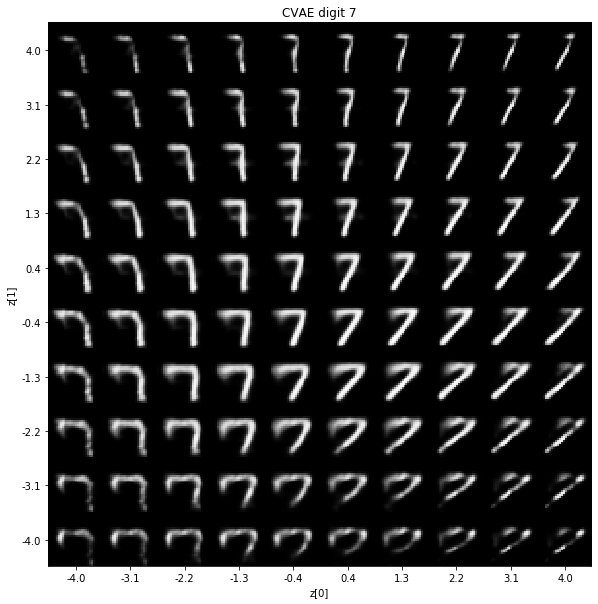

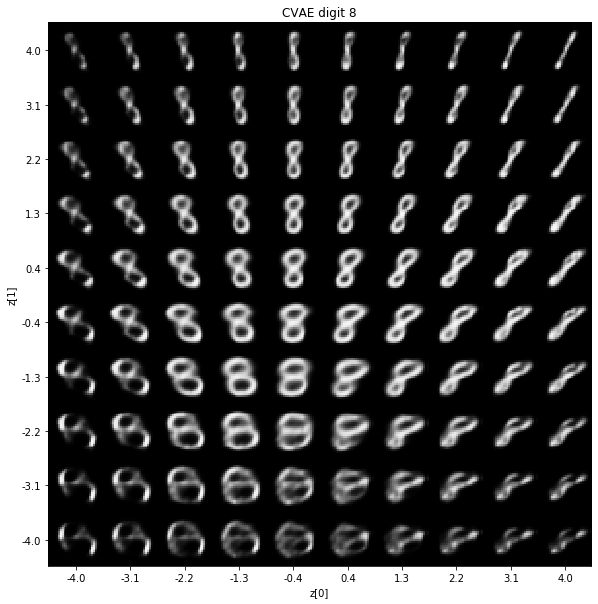

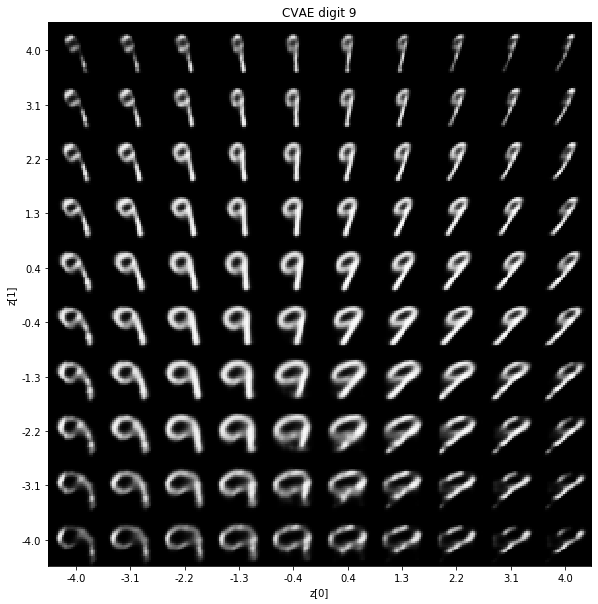

In [21]:
plot_results((encoder,decoder),(xtest,ytest),model_name="vae_cond")